In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import pandas as pd

m = hub.KerasLayer('https://tfhub.dev/google/aiy/vision/classifier/birds_V1/1')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Metal device set to: Apple M1 Max


2022-02-20 22:33:54.122621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-20 22:33:54.122735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-20 22:33:54.133012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 22:33:54.133060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [2]:
import tensorflow as tf

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [3]:
img, img_raw = load_image("https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",image_size=224)

In [3]:
map_pd = pd.read_csv("https://www.gstatic.com/aihub/tfhub/labelmaps/aiy_birds_V1_labelmap.csv")

CPU times: user 43 ms, sys: 124 ms, total: 167 ms
Wall time: 132 ms
(1)  867 - Corvus brachyrhynchos: 0.6514002084732056
(2)  362 - Corvus corax: 0.05490861088037491
(3)  939 - Corvus corone: 0.04656146466732025
(4)  951 - Corvus monedula: 0.026144372299313545
(5)  232 - Euphagus cyanocephalus: 0.026144372299313545


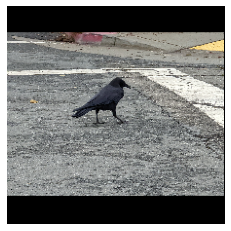

In [34]:
# Run model on image
%time x = m(img)
probabilities = x.numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

for i, item in enumerate(top_5):
    line = f'({i+1}) {item:4} - {map_pd[map_pd.id == item].values[0][1]}: {probabilities[0][top_5][i]}'
    print(line)

show_image(img, '')

In [4]:
import ipywidgets as widgets

In [7]:
btn_upload = widgets.FileUpload()

In [31]:
f=list(btn_upload.value.keys())[0]
img, img_raw = load_image(f,image_size=224)

NotFoundError: PXL_20220220_154236390.jpg; No such file or directory

In [5]:
from ipyfilechooser import FileChooser
fc = FileChooser()

In [6]:
display(fc)

FileChooser(path='/Users/bf/src/birds', filename='', title='', show_hidden=False, select_desc='Select', change…

In [7]:
fc.selected

'/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'

In [8]:
img, img_raw = load_image(fc.selected,image_size=224)

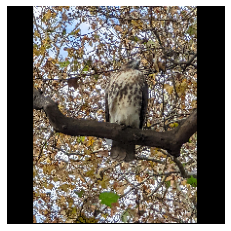

In [9]:
show_image(img)

In [35]:
fc.reset()
display(fc)
img, img_raw = load_image(fc.selected,image_size=224)
%time x = m(img)
probabilities = x.numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

for i, item in enumerate(top_5):
    line = f'({i+1}) {item:4} - {map_pd[map_pd.id == item].values[0][1]}: {probabilities[0][top_5][i]}'
    print(line)

show_image(img, '')

FileChooser(path='/Users/bf/src/birds', filename='', title='', show_hidden=False, select_desc='Select', change…

AttributeError: 'NoneType' object has no attribute 'startswith'

In [19]:
def identify_bird_callback(self):
    
    print(f"Loading '{self.selected}'")
    img, img_raw = load_image(self.selected,image_size=224)
    x = m(img)
    probabilities = x.numpy()

    top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

    for i, item in enumerate(top_5):
        line = f'({i+1}) {item:4} - {map_pd[map_pd.id == item].values[0][1]}: {probabilities[0][top_5][i]}'
        print(line)

    show_image(img, '')
    

FileChooser(path='/Users/bf/src/birds', filename='', title='', show_hidden=False, select_desc='Select', change…

Loading '/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'
CPU times: user 36.1 ms, sys: 99.8 ms, total: 136 ms
Wall time: 109 ms
(1)  867 - Corvus brachyrhynchos: 0.6514002084732056
(2)  362 - Corvus corax: 0.05490861088037491
(3)  939 - Corvus corone: 0.04656146466732025
(4)  951 - Corvus monedula: 0.026144372299313545
(5)  232 - Euphagus cyanocephalus: 0.026144372299313545


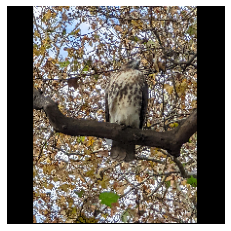

Loading '/Users/bf/src/birds/tests/PXL_20220220_154236390.jpg'
CPU times: user 38 ms, sys: 99.6 ms, total: 138 ms
Wall time: 110 ms
(1)  867 - Corvus brachyrhynchos: 0.6514002084732056
(2)  362 - Corvus corax: 0.05490861088037491
(3)  939 - Corvus corone: 0.04656146466732025
(4)  951 - Corvus monedula: 0.026144372299313545
(5)  232 - Euphagus cyanocephalus: 0.026144372299313545


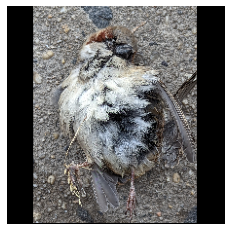

In [45]:
display(fc)

In [11]:
fc.selected

'/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'

Loading '/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'
(1)  608 - Buteo jamaicensis: 0.7925079464912415
(2)  607 - Buteo lineatus: 0.07877892255783081
(3)  738 - Accipiter cooperii: 0.007830983027815819
(4)  507 - Strix varia: 0.0020936578512191772
(5)  343 - Athene noctua: 0.0011755932355299592


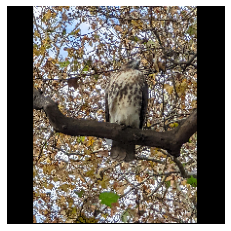

In [14]:
identify_bird(fc)

FileChooser(path='/Users/bf/src/birds', filename='', title='', show_hidden=False, select_desc='Select', change…

Loading '/Users/bf/src/birds/tests/PXL_20211021_195841880.jpg'
(1)  867 - Corvus brachyrhynchos: 0.6514002084732056
(2)  362 - Corvus corax: 0.05490861088037491
(3)  939 - Corvus corone: 0.04656146466732025
(4)  951 - Corvus monedula: 0.026144372299313545
(5)  232 - Euphagus cyanocephalus: 0.026144372299313545


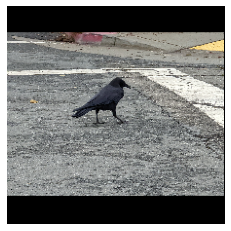

Loading '/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'
(1)  608 - Buteo jamaicensis: 0.7925079464912415
(2)  607 - Buteo lineatus: 0.07877892255783081
(3)  738 - Accipiter cooperii: 0.007830983027815819
(4)  507 - Strix varia: 0.0020936578512191772
(5)  343 - Athene noctua: 0.0011755932355299592


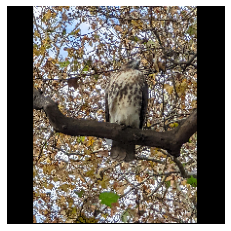

Loading '/Users/bf/src/birds/tests/PXL_20220220_154236390.jpg'
(1)  671 - Passer domesticus: 0.08371694386005402
(2)  661 - Poecile rufescens: 0.055434320122003555
(3)  824 - Anas discors: 0.033801592886447906
(4)  902 - Campylorhynchus brunneicapillus: 0.028663113713264465
(5)  959 - Garrulus glandarius: 0.026394682005047798


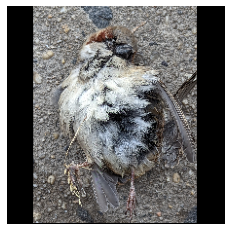

Loading '/Users/bf/src/birds/tests/PXL_20211116_202526038.jpg'
(1)  608 - Buteo jamaicensis: 0.7925079464912415
(2)  607 - Buteo lineatus: 0.07877892255783081
(3)  738 - Accipiter cooperii: 0.007830983027815819
(4)  507 - Strix varia: 0.0020936578512191772
(5)  343 - Athene noctua: 0.0011755932355299592


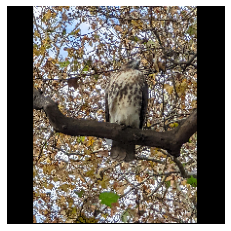

In [15]:
display(fc)

Loading '/Users/bf/src/birds/tests/PXL_20220220_154236390.jpg'
(1)  671 - Passer domesticus: 0.08371694386005402
(2)  661 - Poecile rufescens: 0.055434320122003555
(3)  824 - Anas discors: 0.033801592886447906
(4)  902 - Campylorhynchus brunneicapillus: 0.028663113713264465
(5)  959 - Garrulus glandarius: 0.026394682005047798


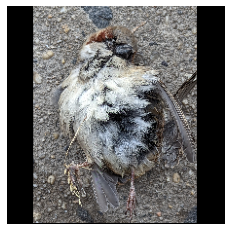

In [16]:
identify_bird(fc)

In [20]:
fc.register_callback(identify_bird_callback)

FileChooser(path='/Users/bf/src/birds', filename='', title='', show_hidden=False, select_desc='Select', change…

Loading '/Users/bf/src/birds/tests/whooping_crane.jpg'
(1)  604 - Ardea alba: 0.20317278802394867
(2)  574 - Bubulcus ibis: 0.13453364372253418
(3)  817 - Cygnus olor: 0.13453364372253418
(4)   11 - Antigone canadensis: 0.08908329904079437
(5)  594 - Grus americana: 0.042416416108608246


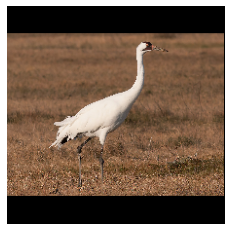

Loading '/Users/bf/src/birds/tests/whooping_crane_2.jpg'
(1)  574 - Bubulcus ibis: 0.3945004940032959
(2)  604 - Ardea alba: 0.17297308146953583
(3)  359 - Eudocimus albus: 0.04624531790614128
(4)   11 - Antigone canadensis: 0.02391180768609047
(5)  562 - Egretta thula: 0.020276760682463646


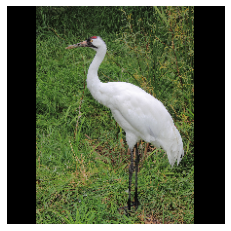

In [18]:
display(fc)

In [22]:
import timeit

In [37]:
timeit.timeit(stmt='x=m(img)',number=1,globals=globals())

0.1232165000110399

In [44]:
def fmt_time(dt):
    time_units = {"nsec": 1e-9, "usec": 1e-6, "msec": 1e-3, "sec": 1.0}
    precision = 3
    scales = [(scale, unit) for unit, scale in time_units.items()]
    scales.sort(reverse=True)
    for scale, unit in scales:
        if dt >= scale:
            break
    return "%.*g %s" % (precision, dt / scale, unit)

pr_time(timeit.timeit(stmt='x=m(img)',number=1,globals=globals()))


'129 msec'

In [43]:
pr_time(timeit.timeit(stmt='x=m(img)',number=1, globals=globals()))


'164 msec'

In [56]:
def identify_bird(image_loc):
    
    print(f"Loading '{image_loc}'")
    img, img_raw = load_image(image_loc,image_size=224)
    t1=time.time()
    x=m(img)
    t2=time.time()
    
    print(f"Model completed in {fmt_time(t2-t1)}")
    
    probabilities = x.numpy()

    top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

    for i, item in enumerate(top_5):
        line = f'({i+1}) {item:4} - {map_pd[map_pd.id == item].values[0][1]}: {probabilities[0][top_5][i]}'
        print(line)

    show_image(img, '')

In [46]:
fc.selected

'/Users/bf/src/birds/tests/whooping_crane_2.jpg'

Loading '/Users/bf/src/birds/tests/whooping_crane_2.jpg'
Model completed in 104 msec
(1)  574 - Bubulcus ibis: 0.3945004940032959
(2)  604 - Ardea alba: 0.17297308146953583
(3)  359 - Eudocimus albus: 0.04624531790614128
(4)   11 - Antigone canadensis: 0.02391180768609047
(5)  562 - Egretta thula: 0.020276760682463646


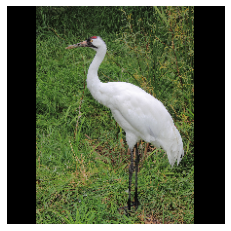

In [57]:
identify_bird(fc.selected)

In [58]:
x=m(img)

In [59]:
type(x)

tensorflow.python.framework.ops.EagerTensor

In [60]:
type(x[0])

tensorflow.python.framework.ops.EagerTensor

In [61]:
p=x.numpy()

In [62]:
type(p)

numpy.ndarray

In [64]:
l = []
l.append(('hi', .95))

## Return a list of the 5 most likely species with probability / confidence as a list of lists of 
## (species, probability)
## The species "background" means couldn't find identify any birds

In [87]:
def identify_bird(image_loc, debug = False):
    
    if debug: print(f"Loading '{image_loc}'")
    img, img_raw = load_image(image_loc,image_size=224)
    t1=time.time()
    x=m(img)
    t2=time.time()
    
    if debug: print(f"Model completed in {fmt_time(t2-t1)}")
    
    probabilities = x.numpy()

    top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

    retval = []
    
    for i, item in enumerate(top_5):
        retval.append((map_pd[map_pd.id == item].values[0][1], probabilities[0][top_5[i]]))
        if debug: print(f'({i+1}) {item:4} - {map_pd[map_pd.id == item].values[0][1]}: {probabilities[0][top_5[i]]}')

    if debug: show_image(img, '')
    return(retval)

In [84]:
debug_identify_bird = False

In [85]:
identify_bird(fc.selected)[0]

('Bubulcus ibis', 0.3945005)

In [86]:
identify_bird(fc.selected, True)

Loading '/Users/bf/src/birds/tests/whooping_crane_2.jpg'
Model completed in 106 msec
(1)  574 - Bubulcus ibis: 0.3945004940032959
(2)  604 - Ardea alba: 0.17297308146953583
(3)  359 - Eudocimus albus: 0.04624531790614128
(4)   11 - Antigone canadensis: 0.02391180768609047
(5)  562 - Egretta thula: 0.020276760682463646


[('Bubulcus ibis', 0.3945005),
 ('Ardea alba', 0.17297308),
 ('Eudocimus albus', 0.046245318),
 ('Antigone canadensis', 0.023911808),
 ('Egretta thula', 0.02027676)]

Loading 'https://www.allaboutbirds.org/guide/assets/photo/308065631-480px.jpg'
Model completed in 92.2 msec
(1)  307 - Columba livia: 0.8881799578666687
(2)  958 - Columba livia domestica: 0.038711339235305786
(3)  417 - Ocyphaps lophotes: 0.0005319592892192304
(4)  781 - Sturnus vulgaris: 0.0004510914150159806
(5)  785 - Toxostoma longirostre: 0.0004510914150159806


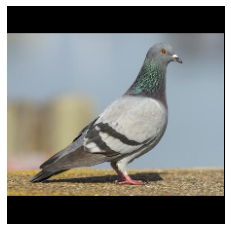

[('Columba livia', 0.88817996),
 ('Columba livia domestica', 0.03871134),
 ('Ocyphaps lophotes', 0.0005319593),
 ('Sturnus vulgaris', 0.00045109142),
 ('Toxostoma longirostre', 0.00045109142)]

In [88]:
identify_bird('https://www.allaboutbirds.org/guide/assets/photo/308065631-480px.jpg',True)

Loading 'https://www.gannett-cdn.com/presto/2021/03/22/NPOH/9d018030-dbd6-4ec3-b9aa-a7613aeb81fc-cardinal.JPEG?width=1320&height=992&fit=crop&format=pjpg&auto=webp'
Model completed in 93.3 msec
(1)   68 - Cardinalis cardinalis: 0.9140681624412537
(2)  153 - Geothlypis trichas: 0.0007010947447270155
(3)  730 - Spinus tristis: 0.0005945151788182557
(4)   91 - Zonotrichia albicollis: 0.0005041375989094377
(5)  721 - Cardellina rubra: 0.0005041375989094377


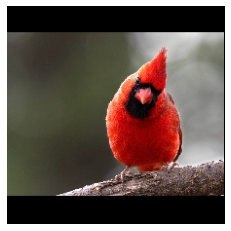

In [89]:
identify_bird('https://www.gannett-cdn.com/presto/2021/03/22/NPOH/9d018030-dbd6-4ec3-b9aa-a7613aeb81fc-cardinal.JPEG?width=1320&height=992&fit=crop&format=pjpg&auto=webp',True)



In [78]:
top_5

array([608, 607, 738, 507, 343], dtype=int32)

In [90]:
map_pd

,id,name
0,964,background
1,0,Haemorhous cassinii
2,1,Aramus guarauna
3,2,Rupornis magnirostris
4,3,Cyanocitta cristata
...,...,...
960,959,Garrulus glandarius
961,960,Anser anser domesticus
962,961,Mitrephanes phaeocercus
963,962,Ardenna creatopus


In [81]:
probabilities[0][608]

0.79250795

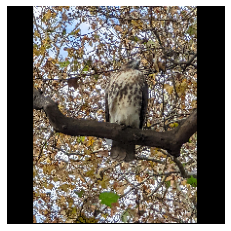

In [82]:
show_image(img)

In [103]:
i="/Users/bf/Downloads/PXL_20220225_010446191.jpg"

Loading '/Users/bf/Downloads/PXL_20220225_010446191.jpg'
Model completed in 102 msec
(1)  672 - Aphelocoma californica: 0.7617224454879761
(2)    4 - Cyanocitta stelleri: 0.010467350482940674
(3)    3 - Cyanocitta cristata: 0.010467350482940674
(4)  759 - Aphelocoma woodhouseii: 0.00817365013062954
(5)  722 - Aphelocoma coerulescens: 0.0042263055220246315


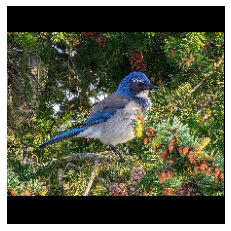

In [105]:
r=identify_bird(i,True)

In [106]:
r[0][1]

0.76172245

In [107]:
r[0]

('Aphelocoma californica', 0.76172245)

In [100]:
if r[0][0] == 'background': print("not a bird")

not a bird


### Will need to install opencv and its dependencies to work directly with camera feeds
```
conda install opencv py-opencv
```

In [ ]:
m??